### Importing Libraries

In [1]:
!pip install keras-tuner --upgrade
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from keras_tuner import GridSearch
import matplotlib.pyplot as plot
from keras.utils import np_utils
import pandas as pd

from IPython.display import display
import time
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.0 MB/s eta 0:00:00


# Grid Search using AdamOptimiser

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

n=30000
x_train = x_train[1:n]
y_train=y_train[1:n]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
def create_Grid_Search_Adam_model(parameters):
    
    selectedLearningRate = parameters.Choice('learning_rate',values=[0.001,0.01,0.1])
    selectedBatchSize = parameters.Choice('batch_size',values= [32,64,128])
    selectedBeta1 = parameters.Choice('beta_1',values= [0.25,0.5,0.9])
    selectedBeta2 = parameters.Choice('beta_2',values= [0.9,0.99,0.999])
   
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    optimizer = Adam(learning_rate=selectedLearningRate, beta_1=selectedBeta1, beta_2=selectedBeta2)
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [4]:
gridSearch_Adam_optimiser = GridSearch(
                        create_Grid_Search_Adam_model,
                        objective = 'val_loss',
                        seed = 42,
                        directory = 'GridSearch_Adam',
                        project_name = 'mnist_data'
                    )


In [5]:
start_time = time.time()
gridSearch_Adam_optimiser.search(x_train, y_train, validation_data = (x_validation, y_validation), epochs = 10)
end_time = time.time()
print(f'\n\nTotal time to execute Grid Search(Adam) is : {end_time - start_time} seconds')

Trial 81 Complete [00h 00m 40s]
val_loss: 2.3064310550689697

Best val_loss So Far: 0.03997322544455528
Total elapsed time: 00h 57m 45s


Total time to execute Grid Search(Adam) is : 3465.105231523514 seconds


In [7]:
gridSearch_Adam_param_values = gridSearch_Adam_optimiser.oracle.trials.values()

trainingLoss_data = []
validationLoss_data = []
bestTrainingLoss_data = []
bestValidationLoss_data = []

currentBestTrainingLoss = currentBestValidationLoss = float("inf")


parameters = []
counter = 1

for parameter in gridSearch_Adam_param_values:
    trainingLoss = parameter.metrics.get_history('loss')[-1].value[0]
    validationLoss = parameter.metrics.get_history('val_loss')[-1].value[0]
    trainingAccuracy = parameter.metrics.get_history('accuracy')[-1].value[0]
    validationAccuracy = parameter.metrics.get_history('val_accuracy')[-1].value[0]
    trainingLoss_data.append(trainingLoss)
    validationLoss_data.append(validationLoss)
    
    parameter_dictionary = {
        "Trial": counter,
        "Learning Rate": parameter.hyperparameters.get("learning_rate"),
        "Batch Size": parameter.hyperparameters.get("batch_size"),
        "Beta 1": parameter.hyperparameters.get("beta_1"),
        "Beta 2": parameter.hyperparameters.get("beta_2"),
        "Training Accuracy": trainingAccuracy,
        "Validation Accuracy": validationAccuracy,
        "Training Loss": trainingLoss,
        "Validation Loss": validationLoss
    }
    
    if validationLoss < currentBestValidationLoss:
        currentBestValidationLoss = validationLoss
    
    if trainingLoss < currentBestTrainingLoss:
        currentBestTrainingLoss = trainingLoss
    
    bestTrainingLoss_data.append(currentBestTrainingLoss)
    bestValidationLoss_data.append(currentBestValidationLoss)
    
    parameters.append(parameter_dictionary)
    counter += 1

gridSearch_Adam_Parameters_df = pd.DataFrame(parameters)


In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
display(gridSearch_Adam_Parameters_df)


,Trial,Learning Rate,Batch Size,Beta 1,Beta 2,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.001,32,0.25,0.900,0.985208,0.984333,0.052009,0.048030
1,2,0.001,32,0.25,0.990,0.987041,0.987500,0.039979,0.042681
2,3,0.001,32,0.25,0.999,0.985208,0.985833,0.046092,0.046381
3,4,0.001,32,0.50,0.900,0.985291,0.985000,0.049787,0.051356
4,5,0.001,32,0.50,0.990,0.987958,0.986333,0.038432,0.043369
5,6,0.001,32,0.50,0.999,0.984708,0.984667,0.048994,0.048907
6,7,0.001,32,0.90,0.900,0.985541,0.986333,0.046276,0.044697
7,8,0.001,32,0.90,0.990,0.985791,0.986500,0.043330,0.044414
8,9,0.001,32,0.90,0.999,0.986916,0.986167,0.039863,0.044320
9,10,0.001,64,0.25,0.900,0.985624,0.987500,0.047612,0.045710


In [9]:
testLoss_data = []
bestTestLoss_data = []
currentBestTestLoss = float("inf")
optimisedParameters = {}

counter = 1

for parameter in tqdm(gridSearch_Adam_param_values):
    
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    optimizer = Adam(learning_rate=parameter.hyperparameters.get('learning_rate'), beta_1=parameter.hyperparameters.get('beta_1'), beta_2=parameter.hyperparameters.get('beta_2'))
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size = parameter.hyperparameters.get('batch_size'), epochs = 10, verbose=0)
    testLoss, testAccuracy = model.evaluate(x_test, y_test, verbose=0)
    testLoss_data.append(testLoss)
    
    if testLoss < currentBestTestLoss:
        currentBestTestLoss = testLoss
        optimisedParameters = {
                                    "Trial": counter,
                                    "Learning Rate": parameter.hyperparameters.get("learning_rate"),
                                    "Batch Size": parameter.hyperparameters.get("batch_size"),
                                    "Beta 1": parameter.hyperparameters.get("beta_1"),
                                    "Beta 2": parameter.hyperparameters.get("beta_2"),
                                    "Test Accuracy": testAccuracy,
                                    "Test Loss": testLoss
                              }
    bestTestLoss_data.append(currentBestTestLoss)
        
    counter += 1
    

100%|██████████| 81/81 [30:04<00:00, 22.28s/it]


In [10]:
gridSearch_Adam_Test_Parameters_df = pd.DataFrame([optimisedParameters])
display(gridSearch_Adam_Test_Parameters_df)

,Trial,Learning Rate,Batch Size,Beta 1,Beta 2,Test Accuracy,Test Loss
0,5,0.001,32,0.5,0.99,0.9896,0.03128


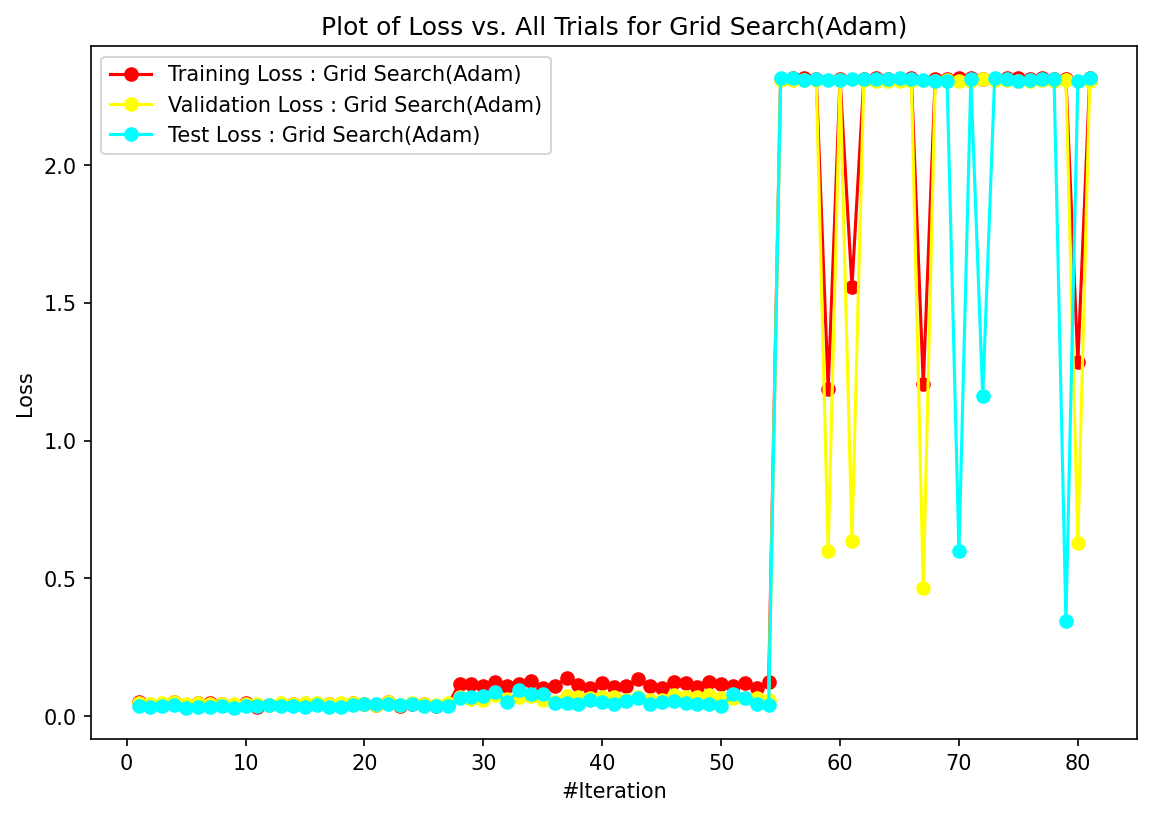

In [11]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(gridSearch_Adam_param_values) + 1), trainingLoss_data, label="Training Loss : Grid Search(Adam)", marker='o', color="Red")
plot.plot(range(1, len(gridSearch_Adam_param_values) + 1), validationLoss_data, label="Validation Loss : Grid Search(Adam)", marker='o', color="Yellow")
plot.plot(range(1, len(gridSearch_Adam_param_values) + 1), testLoss_data, label="Test Loss : Grid Search(Adam)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Loss")
plot.title('Plot of Loss vs. All Trials for Grid Search(Adam)')
plot.legend()
plot.show()

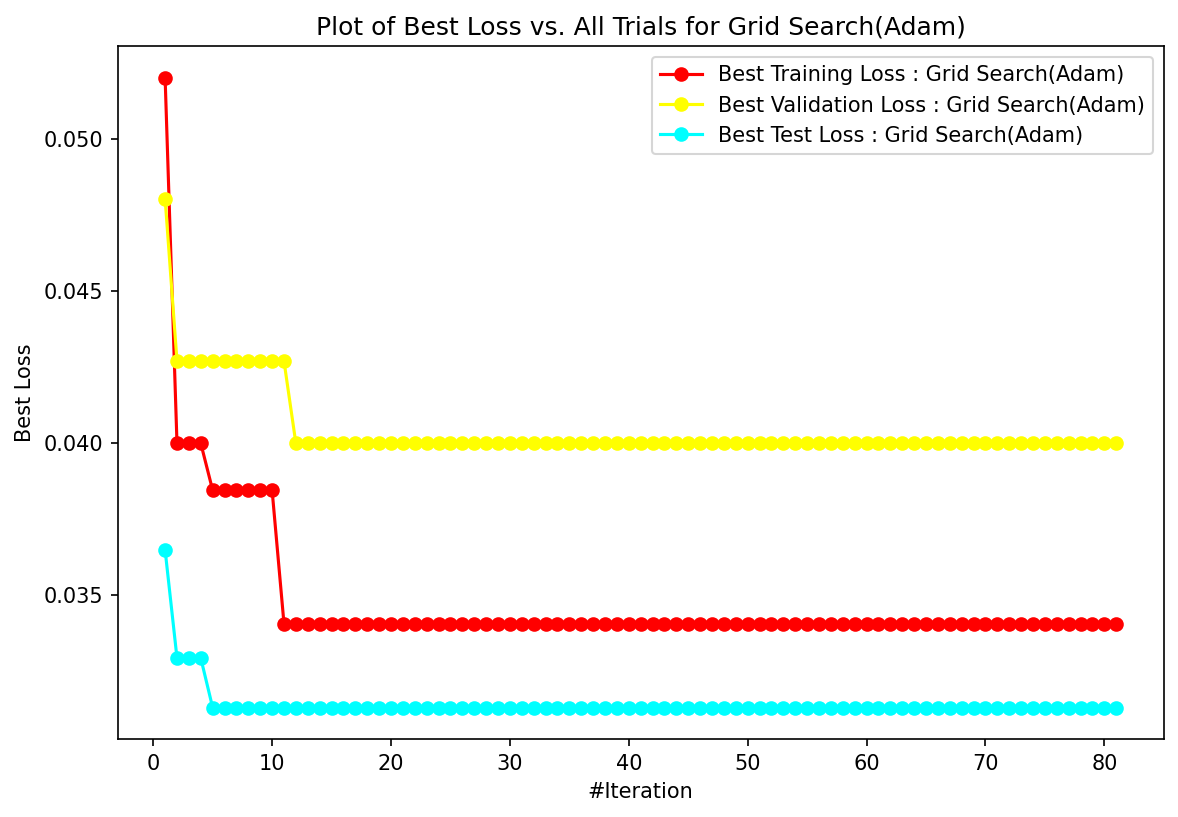

In [12]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(gridSearch_Adam_param_values) + 1), bestTrainingLoss_data, label="Best Training Loss : Grid Search(Adam)", marker='o', color="Red")
plot.plot(range(1, len(gridSearch_Adam_param_values) + 1), bestValidationLoss_data, label="Best Validation Loss : Grid Search(Adam)", marker='o', color="Yellow")
plot.plot(range(1, len(gridSearch_Adam_param_values) + 1), bestTestLoss_data, label="Best Test Loss : Grid Search(Adam)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Best Loss")
plot.title('Plot of Best Loss vs. All Trials for Grid Search(Adam)')
plot.legend()
plot.show()

In [13]:
bestTest_GS_Adam_DF = pd.DataFrame(bestTestLoss_data, columns=['BestTestLoss_GS_Adam'])
bestTest_GS_Adam_DF.to_csv('GridSearch_Adam_BestTestLoss.csv', index=False)